In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE

from keras.models import Sequential
from keras.utils import np_utils
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPool2D, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
!pip install focal-loss
from focal_loss import BinaryFocalLoss

import tensorflow as tf

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))


/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/person141_bacteria_678.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/person109_bacteria_512.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/person111_bacteria_533.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/person149_bacteria_713.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/person28_virus_62.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/person175_bacteria_833.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/person128_bacteria_606.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/person1644_virus_2844.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/person143_bacteria_687.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/person101_bacteria_483.jpeg
/kaggl

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0336-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0101-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0337-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0198-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0013-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0103-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0139-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0313-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0340-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0378-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-00

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1230_virus_2081.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1513_virus_2632.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person124_virus_238.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person746_virus_1369.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person588_bacteria_2422.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person466_virus_960.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1590_bacteria_4175.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person399_bacteria_1805.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person59_bacteria_279.jpe

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person480_virus_982.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person500_virus_1009.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person397_virus_790.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1495_virus_2603.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person813_virus_1449.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person5_bacteria_17.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1256_bacteria_3214.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person549_bacteria_2303.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1251_bacteria_3208.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person515_bacteria_2187.jpe

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0771-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1294-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0675-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1169-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0421-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0531-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0416-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0965-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0627-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0997-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/

/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/._PNEUMONIA
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/._NORMAL
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/._.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person499_bacteria_2104.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person515_bacteria_2190.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person426_virus_873.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1171_bacteria_3118.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1119_virus_1844.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1507_bacteria_3942.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUM

/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1225_bacteria_3180.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1537_bacteria_4020.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person410_bacteria_1825.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1639_bacteria_4345.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1779_bacteria_4626.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person918_bacteria_2843.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1496_bacteria_3905.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1296_virus_2224.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person156

/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0473-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0416-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0696-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1419-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0343-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0753-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0851-0001-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1292-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0626-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xra

/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1676_virus_2892.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1650_virus_2852.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person22_virus_55.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person122_bacteria_582.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person85_bacteria_417.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person79_virus_148.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person29_virus_64.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person123_bacteria_587.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person75_virus_136.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person153_bacteria_725.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person173_bacteria_831.jpeg
/kaggle/input/chest-xray-pneumonia/chest_x

/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1230_virus_2081.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1513_virus_2632.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person124_virus_238.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person746_virus_1369.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person588_bacteria_2422.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person466_virus_960.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1590_bacteria_4175.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person399_bacteria_1805.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person59_bacteria_279.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person57_bacteria_270.jpeg
/kaggle/input/chest

/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person938_bacteria_2863.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1555_bacteria_4059.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person14_bacteria_51.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person554_bacteria_2323.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1186_virus_2022.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person501_bacteria_2115.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person480_bacteria_2039.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person281_bacteria_1328.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1343_bacteria_3417.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person421_virus_866.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person331_virus_684.jpeg
/kaggle/in

/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0771-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1294-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0675-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1169-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0421-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0531-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0416-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0965-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0627-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0997-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0757-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0629-0001

In [2]:
### Defining Load Function
size=180
CodeLabel = {"NORMAL":0, "PNEUMONIA":1}

def load_data(main_dir):
    X = []
    y = []
    for sub_dir in os.listdir(main_dir):
        inner_dir=os.path.join(main_dir,sub_dir)
        for i in os.listdir(inner_dir):
            img=cv2.imread(os.path.join(inner_dir,i),0)
            img=cv2.resize(img,(size,size))
            X.append(img)
            y.append(CodeLabel[sub_dir])
    data = zip(X,y)
    zipped_data = list(data)
    random.shuffle(zipped_data)
    unzipped_data = [list(t) for t in zip(*zipped_data)]
    X_new = unzipped_data[0]
    y_new = unzipped_data[1]


    return X_new,y_new
            

**Loading Data**

In [3]:
### Reading data
train_X, train_y =load_data('../input/chest-xray-pneumonia/chest_xray/train')
val_X, val_y  = load_data('../input/chest-xray-pneumonia/chest_xray/val')
test_X, test_y  = load_data('../input/chest-xray-pneumonia/chest_xray/test')

In [4]:
### Checking Data Size
print(len(train_X), len(train_y))
print(len(val_X), len(val_y))
print(len(test_X), len(test_y))

5216 5216
16 16
624 624


It looks like validation dataset is not big enough. I am going to pick random data from training dataset, append to validation dataset and remove from traning (validation dataset to be at least 15% of training dataset)

In [5]:
### Random indexes
random_ix = []

while len(random_ix)<484:
    ix = random.randint(0, len(train_X))
    if ix not in random_ix:
        random_ix.append(ix)
#print(random_ix)
print(len(random_ix))

484


In [6]:
val_X_new = [train_X[i] for i in random_ix]
val_y_new = [train_y[i] for i in random_ix]

val_X_new = val_X_new+val_X
val_y_new = val_y_new+val_y

print("New validation dataset size:")
print(len(val_X_new))

train_X_new = np.delete(train_X, random_ix, axis=0)
train_y_new = np.delete(train_y, random_ix, axis=0)

print("New training dataset size:")
print(len(train_X_new))

New validation dataset size:
500
New training dataset size:
4732


In [7]:
### Cheking size by the class
normal=[]
pneumonia=[]
for ix in range(len(train_X_new)):
    if train_y_new[ix]==0:
        normal.append(train_X_new[ix])
    else:
        pneumonia.append(train_X_new[ix]) 
        
print("Pneumonia samples in training dataset:", len(pneumonia))
print("Normal samples in training dataset:", len(normal))

normal_val=[]
pneumonia_val=[]
for ix in range(len(val_X_new)):
    if val_y_new[ix]==0:
        normal_val.append(val_X_new[ix])
    else:
        pneumonia_val.append(val_X_new[ix]) 
        
print("Pneumonia samples in validation dataset:", len(pneumonia_val))
print("Normal samples in validation dataset:", len(normal_val))

normal_test=[]
pneumonia_test=[]
for ix in range(len(test_X)):
    if test_y[ix]==0:
        normal_test.append(test_X[ix])
    else:
        pneumonia_test.append(test_X[ix]) 
        
print("Pneumonia samples in testing dataset", len(pneumonia_test))
print("Normal samples in testing dataset:", len(normal_test))

Pneumonia samples in training dataset: 3519
Normal samples in training dataset: 1213
Pneumonia samples in validation dataset: 364
Normal samples in validation dataset: 136
Pneumonia samples in testing dataset 390
Normal samples in testing dataset: 234


We have less plenuomonia cases; especially in training dataset. This problem can be tackled by altering the class wight and using focal loss to down weights the correctly classified examples (majority class). Other approach would beto utilise oversampling and undersampling approaches.

**Show Sample Images**

In [8]:
def show_sample(Data, Label):
    plt.figure(figsize=(10,10))
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(Data[i], cmap='gray')
        if Label==1:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

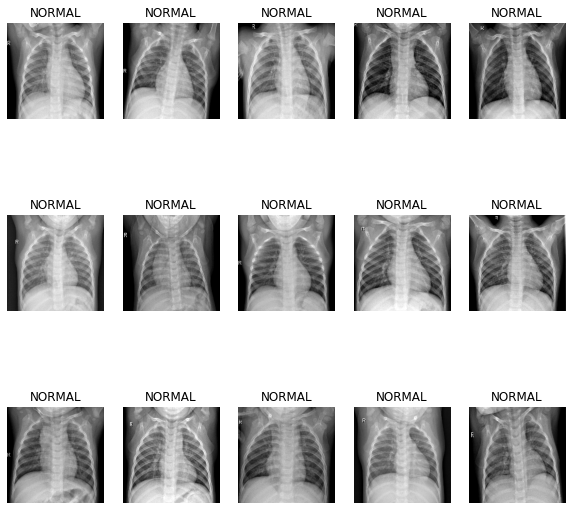

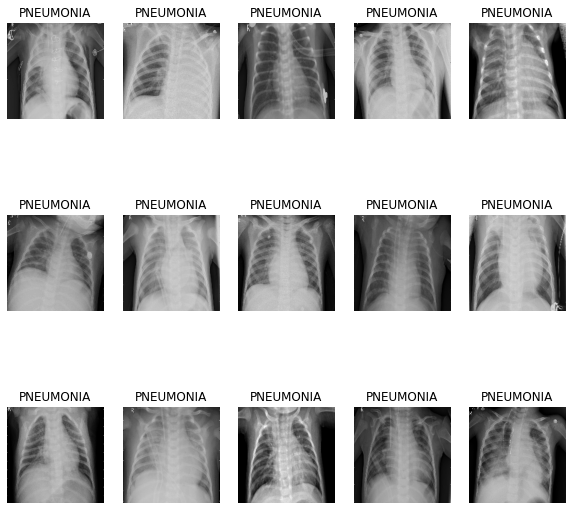

In [9]:
show_sample(normal,0)
show_sample(pneumonia,1)

In [64]:
'''
### Preparing Data
train_X=np.array(train_X_new)/255
val_X=np.array(val_X_new)/255
test_X=np.array(test_X)/255

train_X=train_X.reshape(-1,size,size,1)
val_X=val_X.reshape(-1,size,size,1)
test_X=test_X.reshape(-1,size,size,1)

train_y=np.array(train_y_new)
val_y=np.array(val_y_new)
test_y=np.array(test_y)

### Cehcking the size
print(len(train_X), len(train_y))
print(len(val_X), len(val_y))
print(len(test_X), len(test_y))
'''

'\n### Preparing Data\ntrain_X=np.array(train_X_new)/255\nval_X=np.array(val_X_new)/255\ntest_X=np.array(test_X)/255\n\ntrain_X=train_X.reshape(-1,size,size,1)\nval_X=val_X.reshape(-1,size,size,1)\ntest_X=test_X.reshape(-1,size,size,1)\n\ntrain_y=np.array(train_y_new)\nval_y=np.array(val_y_new)\ntest_y=np.array(test_y)\n\n### Cehcking the size\nprint(len(train_X), len(train_y))\nprint(len(val_X), len(val_y))\nprint(len(test_X), len(test_y))\n'

In [65]:
'''from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

### Preparing Data
train_X=np.array(train_X_new)/255
train_X_orig_shape = train_X.shape
#### Reshape
train_X_reshaped = np.reshape(train_X, (train_X.shape[0],train_X.shape[1]* train_X.shape[2]))
test_y=np.array(train_y_new)
#### Smote
train_X_smote,train_y_smote= sm.fit_resample(train_X_reshaped,test_y)
###Reshape back to original
train_X_smote_reshaped = train_X_smote.reshape(train_X_smote.shape[0], -1)
train_X_smote_orig = np.reshape(train_X_smote_reshaped, (train_X_smote_reshaped.shape[0],train_X_orig_shape[1],train_X_orig_shape[2]))
'''

'from imblearn.over_sampling import SMOTE\nsm = SMOTE(random_state=42)\n\n### Preparing Data\ntrain_X=np.array(train_X_new)/255\ntrain_X_orig_shape = train_X.shape\n#### Reshape\ntrain_X_reshaped = np.reshape(train_X, (train_X.shape[0],train_X.shape[1]* train_X.shape[2]))\ntest_y=np.array(train_y_new)\n#### Smote\ntrain_X_smote,train_y_smote= sm.fit_resample(train_X_reshaped,test_y)\n###Reshape back to original\ntrain_X_smote_reshaped = train_X_smote.reshape(train_X_smote.shape[0], -1)\ntrain_X_smote_orig = np.reshape(train_X_smote_reshaped, (train_X_smote_reshaped.shape[0],train_X_orig_shape[1],train_X_orig_shape[2]))\n'

In [10]:
### Preparing Data
train_X=np.array(train_X_new)/255
val_X=np.array(val_X_new)/255
test_X=np.array(test_X)/255

train_y=np.array(train_y_new)
val_y=np.array(val_y_new)
test_y=np.array(test_y)

### Smote on training data 
sm = SMOTE(random_state=42)

### Preparing Data
train_X_orig_shape = train_X.shape
val_X_orig_shape =val_X.shape

#### Reshape
train_X_reshaped = np.reshape(train_X, (train_X.shape[0],train_X.shape[1]* train_X.shape[2]))
val_X_reshaped = np.reshape(val_X, (val_X.shape[0],val_X.shape[1]* val_X.shape[2]))

#### Smote
train_X_smote,train_y_smote= sm.fit_resample(train_X_reshaped,train_y)

sm = SMOTE(random_state=42)
val_X_smote,val_y_smote= sm.fit_resample(val_X_reshaped,val_y)

###Reshape back to original
train_X_smote_reshaped = train_X_smote.reshape(train_X_smote.shape[0], -1)
train_X_smote_orig = np.reshape(train_X_smote_reshaped, (train_X_smote_reshaped.shape[0],train_X_orig_shape[1],train_X_orig_shape[2]))

val_X_smote_reshaped = val_X_smote.reshape(val_X_smote.shape[0], -1)
val_X_smote_orig = np.reshape(val_X_smote_reshaped, (val_X_smote_reshaped.shape[0],val_X_orig_shape[1],val_X_orig_shape[2]))

###Final reshape to 4D 
train_X_smote=train_X_smote_orig.reshape(-1,size,size,1)
train_X=train_X.reshape(-1,size,size,1)
val_X=val_X.reshape(-1,size,size,1)
val_X_smote= val_X_smote_orig.reshape(-1,size,size,1)
test_X=test_X.reshape(-1,size,size,1)

In [11]:
### Final data size
print("Original training set size:")
print(len(train_X), len(train_y))
print("Smote augmented training set size:")
print(len(train_X_smote), len(train_y_smote))
print("Validation set size:")
print(len(val_X), len(val_y))
print("Smote augmented validation set size:")
print(len(val_X_smote), len(val_y_smote))
print("Test set size:")
print(len(test_X), len(test_y))

Original training set size:
4732 4732
Smote augmented training set size:
7038 7038
Validation set size:
500 500
Smote augmented validation set size:
728 728
Test set size:
624 624


In [12]:
normal_train_smote=[]
pneumonia_train_smote=[]
for ix in range(len(train_X_smote)):
    if train_y_smote[ix]==0:
        normal_train_smote.append(train_X_smote[ix])
    else:
        pneumonia_train_smote.append(train_X_smote[ix]) 
        
print("Pneumonia samples in training dataset after SMOTE:", len(pneumonia_train_smote))
print("Normal samples in training dataset after SMOTE:", len(normal_train_smote))

Pneumonia samples in training dataset after SMOTE: 3519
Normal samples in training dataset after SMOTE: 3519


In [14]:
normal_val_smote=[]
pneumonia_val_smote=[]
for ix in range(len(val_X_smote)):
    if val_y_smote[ix]==0:
        normal_val_smote.append(val_X_smote[ix])
    else:
        pneumonia_val_smote.append(val_X_smote[ix]) 
        
print("Pneumonia samples in training dataset after SMOTE:", len(pneumonia_val_smote))
print("Normal samples in training dataset after SMOTE:", len(normal_val_smote))

Pneumonia samples in training dataset after SMOTE: 364
Normal samples in training dataset after SMOTE: 364


**Steps to icrease number of samples and direct the unbalanced class problem:**

* Image Generator
* Focal Loss custom function
* Class balancing
* Callback list - early stopping & reducing learning rate

In [24]:
### Generating New Images
image_gen=ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,horizontal_flip=True)

In [31]:
#### Cnn architecture
model = Sequential()
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (180,180,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
#model.compile(optimizer = "adam" , loss = BinaryFocalLoss(gamma=2) , metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 180, 180, 64)      640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 180, 180, 64)      256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        18464     
_________________________________________________________________
dropout_9 (Dropout)          (None, 90, 90, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 90, 90, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)       

In [26]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=4)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience = 2,  verbose=1,factor=0.25, min_lr=0.000001)

In [30]:
weights = compute_class_weight('balanced', np.unique(train_y), train_y)
new_weights = dict(zip( np.unique(train_y), weights))
print(new_weights)

{0: 1.9505358615004122, 1: 0.6723500994600738}


In [ ]:
val_X, val_y

In [32]:
## test 1 - adjusted weight and no smote
history = model.fit(image_gen.flow(train_X,train_y, batch_size = 25),epochs = 20 ,validation_data = image_gen.flow(val_X, val_y),class_weight=new_weights,  callbacks = [reduce_lr])

Epoch 1/20
190/190 [==============================] - 15s 74ms/step - loss: 1.0747 - accuracy: 0.7592 - val_loss: 11.8134 - val_accuracy: 0.7280
Epoch 2/20
190/190 [==============================] - 14s 73ms/step - loss: 0.3393 - accuracy: 0.8597 - val_loss: 0.5117 - val_accuracy: 0.7820
Epoch 3/20
190/190 [==============================] - 14s 73ms/step - loss: 0.4037 - accuracy: 0.8352 - val_loss: 3.3148 - val_accuracy: 0.7280
Epoch 4/20
190/190 [==============================] - 14s 71ms/step - loss: 0.3505 - accuracy: 0.8531 - val_loss: 0.8473 - val_accuracy: 0.7520

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/20
190/190 [==============================] - 14s 74ms/step - loss: 0.2409 - accuracy: 0.8997 - val_loss: 0.3151 - val_accuracy: 0.9020
Epoch 6/20
190/190 [==============================] - 14s 72ms/step - loss: 0.1935 - accuracy: 0.9169 - val_loss: 1.1688 - val_accuracy: 0.7880
Epoch 7/20
190/190 [==============================] - 

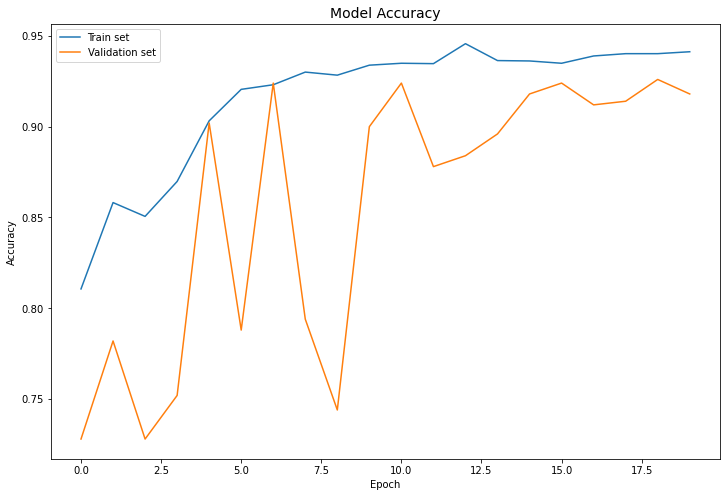

In [33]:
plt.subplots(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=14)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train set', 'Validation set'], loc='upper left')
plt.show()

In [36]:
prediction=model.predict_classes(test_X)

print("Test Accuracy: {:.2f}".format(accuracy_score(prediction, test_y)))

print("Clasifcation Report:")
print(classification_report(prediction, test_y))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test Accuracy: 0.87
Clasifcation Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       196
           1       0.94      0.86      0.90       428

    accuracy                           0.87       624
   macro avg       0.84      0.87      0.85       624
weighted avg       0.88      0.87      0.87       624



<AxesSubplot:>

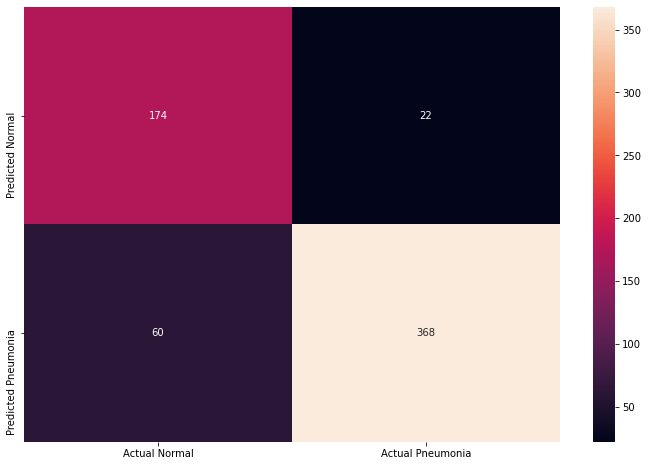

In [38]:
plt.subplots(figsize=(12,8))
cm = pd.DataFrame(data=confusion_matrix(prediction, test_y, labels=[0, 1]),columns=["Actual Normal", "Actual Pneumonia"],
index=["Predicted Normal", "Predicted Pneumonia"])

sns.heatmap(cm,annot=True,fmt="d")

In [47]:
#### Cnn architecture
model = Sequential()
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (180,180,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 180, 180, 64)      640       
_________________________________________________________________
batch_normalization_20 (Batc (None, 180, 180, 64)      256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 90, 90, 32)        18464     
_________________________________________________________________
dropout_15 (Dropout)         (None, 90, 90, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 90, 90, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 45, 45, 32)       

In [48]:
### Test 2 SMOTE
history2 = model.fit(image_gen.flow(train_X_smote,train_y_smote, batch_size = 25),epochs = 20 ,validation_data = image_gen.flow(val_X_smote, val_y_smote),  callbacks = [reduce_lr])

Epoch 1/20
282/282 [==============================] - 21s 72ms/step - loss: 1.0261 - accuracy: 0.7548 - val_loss: 8.5551 - val_accuracy: 0.5000
Epoch 2/20
282/282 [==============================] - 21s 74ms/step - loss: 0.2790 - accuracy: 0.8968 - val_loss: 9.6389 - val_accuracy: 0.5000
Epoch 3/20
282/282 [==============================] - 21s 73ms/step - loss: 0.2711 - accuracy: 0.9014 - val_loss: 1.2616 - val_accuracy: 0.5920
Epoch 4/20
282/282 [==============================] - 20s 71ms/step - loss: 0.2422 - accuracy: 0.9107 - val_loss: 1.0535 - val_accuracy: 0.6992
Epoch 5/20
282/282 [==============================] - 20s 72ms/step - loss: 0.1989 - accuracy: 0.9195 - val_loss: 0.8228 - val_accuracy: 0.7871
Epoch 6/20
282/282 [==============================] - 20s 70ms/step - loss: 0.2027 - accuracy: 0.9320 - val_loss: 0.8392 - val_accuracy: 0.7761
Epoch 7/20
282/282 [==============================] - 21s 73ms/step - loss: 0.2210 - accuracy: 0.9244 - val_loss: 0.5273 - val_accuracy:

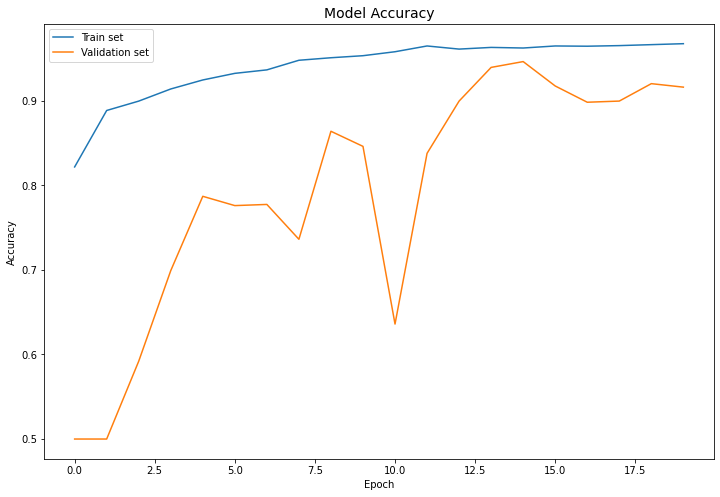

In [50]:
plt.subplots(figsize=(12,8))
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy', size=14)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train set', 'Validation set'], loc='upper left')
plt.show()

In [51]:
prediction=model.predict_classes(test_X)

print("Test Accuracy: {:.2f}".format(accuracy_score(prediction, test_y)))
print("Clasifcation Report:")
print(classification_report(prediction, test_y))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test Accuracy: 0.89
Clasifcation Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       200
           1       0.96      0.88      0.92       424

    accuracy                           0.89       624
   macro avg       0.87      0.90      0.88       624
weighted avg       0.90      0.89      0.90       624



<AxesSubplot:>

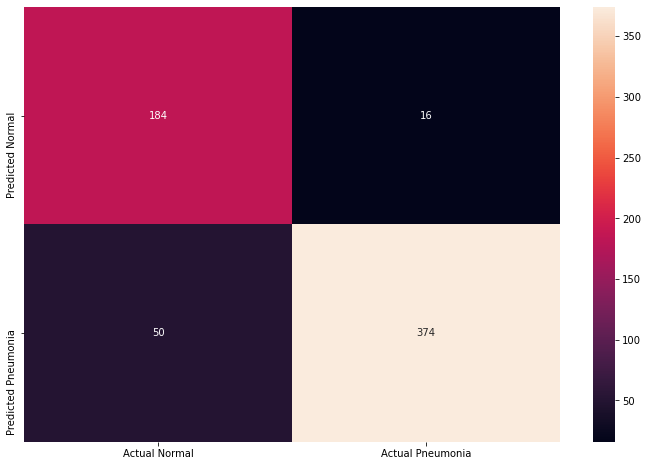

In [52]:
plt.subplots(figsize=(12,8))
cm = pd.DataFrame(data=confusion_matrix(prediction, test_y, labels=[0, 1]),columns=["Actual Normal", "Actual Pneumonia"],
index=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")